In [1]:
# ==================
# INSTALL AND LOAD LIBRARIES
# ==================
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install xgboost
!pip install joblib

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import math
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from dataclasses import dataclass
from typing import List, Tuple
import sys
import os

In [2]:
# Add the scr folder to the Python path
sys.path.append('./src')

# Load custom library (soccer_dynamics_1.py)
from soccer_dynamics_1 import load_match_data, calculate_metrics, train_xgb_model
from soccer_dynamics_1 import calculate_metrics_extended, calculate_teammate_metrics, Point, distance

In [ ]:
# Calculate start and end frame metrics using tracking data

# Match IDs
match_ids = [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461]

# Common inputs
Lf_OBR = 0.2
Lf_PO = 0.8
Lf_OBE = 0.1

# Lists to collect all_M_end DataFrames across matches
all_M_end_list = []

# Maximum number of teammates to include (excluding GK and possession player)
MAX_TEAMMATES = 8  # Maximum 10 outfield players - 1 possession player - 1 primary pass target player  = 8

# Loop through each match_id
for match_id in match_ids:
    print(f"Processing match {match_id}...")
    
    # Load and process event and tracking data for current match
    po_obr, tracking = load_match_data(match_id)
       
    # Process frame_end
    frame_type = 'frame_end'
    M_list = []
    for idx, row in po_obr.iterrows():
        frame_num = row[frame_type]
        primary_teammate_id = row['player_id']
        event_id = row['event_id']  # Get event_id from the row
        
        # Get tracking data for this frame
        frame_data = tracking[tracking['frame'] == frame_num]
        if frame_data.empty:
            continue
            
        # Get possession player for this frame
        possession_players = list(set(frame_data['possession_player_id']))
        if not possession_players:
            continue
        possession_player_id = int(possession_players[0])
        
        # Skip if primary teammate is the same as possession player
        if primary_teammate_id == possession_player_id:
            continue
        
        # Calculate metrics for the primary teammate (from po_obr)
        M = calculate_metrics_extended(frame_type, frame_num, Lf_OBR, Lf_PO, Lf_OBE, 
                                      po_obr, tracking, match_id, possession_player_id, 
                                      primary_teammate_id, event_id)  # Pass event_id here
        
        if M is not None:
            # Get all other teammate player_ids (non-GK, in possession flag, excluding possession player and primary teammate)
            other_teammates = frame_data[
                (frame_data['possession_flag'] == 'IP') & 
                (frame_data['is_gk'] == False) &
                (frame_data['player_id'] != possession_player_id) &
                (frame_data['player_id'] != primary_teammate_id)
            ]['player_id'].unique()
            
            # Calculate distances and sort other teammates by distance to ball carrier
            teammate_distances = []
            
            # Get ball carrier coordinates once
            ball_carrier_data = frame_data[frame_data['player_id'] == possession_player_id]
            if not ball_carrier_data.empty:
                x_B = float(ball_carrier_data['x'].iloc[0])
                y_B = float(ball_carrier_data['y'].iloc[0])
                B = Point(x_B, y_B)
                
                for teammate_id in other_teammates:
                    teammate_data = frame_data[frame_data['player_id'] == teammate_id]
                    if not teammate_data.empty:
                        x_T = float(teammate_data['x'].iloc[0])
                        y_T = float(teammate_data['y'].iloc[0])
                        T = Point(x_T, y_T)
                        
                        dist = distance(B, T)
                        teammate_distances.append((teammate_id, dist))
            
            # Sort teammates by distance (closest to furthest)
            sorted_teammates = sorted(teammate_distances, key=lambda x: x[1])
            
            # Calculate metrics for additional teammates (closest to furthest, up to MAX_TEAMMATES)
            for i, (teammate_id, dist) in enumerate(sorted_teammates[:MAX_TEAMMATES]):
                # Calculate metrics for this additional teammate
                M_teammate = calculate_teammate_metrics(frame_num, Lf_OBR, Lf_PO, Lf_OBE,
                                                       tracking, possession_player_id, teammate_id)
                
                if M_teammate is not None:
                    # Add teammate metrics as new columns
                    for col, value in M_teammate.items():
                        M[f'{col}_teammate_{i+1}'] = value
                else:
                    # Add NaN values if metrics couldn't be calculated
                    for col in ['Theta_a_OBR', 'Theta_d_OBR', 'Theta_b_OBR', 'da_OBR', 'dd_OBR', 'db_OBR',
                               'Theta_d_PO', 'Theta_b_PO', 'dd_PO', 'db_PO']:
                        M[f'{col}_teammate_{i+1}'] = np.nan
            
            M_list.append(M)
    
    if M_list:
        M_end = pd.concat(M_list, ignore_index=True)
        M_end['match_id'] = match_id
        all_M_end_list.append(M_end)
        print(f"  Created M_end with {len(M_list)} rows")

# Concatenate all results    
if all_M_end_list:
    all_M_end = pd.concat(all_M_end_list, ignore_index=True)

In [ ]:
# Save calculated metrics to xlsx
all_M_end.to_excel('all_M_end.xlsx', index=False)

In [60]:
# Load calculated metrics
all_M_end = pd.read_excel('all_M_end.xlsx')
M = all_M_end.copy()
M = M[(M['xthreat'] < 0.02) & (M['xthreat'] > 0)]

In [61]:
# Setup data for regression model

# Select test match_id
match_id_test = 1886347
    # [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461]

# Remove test match_id from master dataset
M_train = M[M['match_id'] != match_id_test]

# Drop columns for X, Y, and M_train
X = M_train.drop(columns = ['xthreat','match_id', 'frame','frame_type','possession_player_id','teammate_player_id','event_id'])
Y = M_train[['xthreat']]
M_train = M_train.drop(columns = ['match_id','frame','frame_type','possession_player_id','teammate_player_id','event_id'])

# Create X and Y for regression
X = X.values
Y = Y.values

Fitting 5 folds for each of 1 candidates, totalling 5 fits


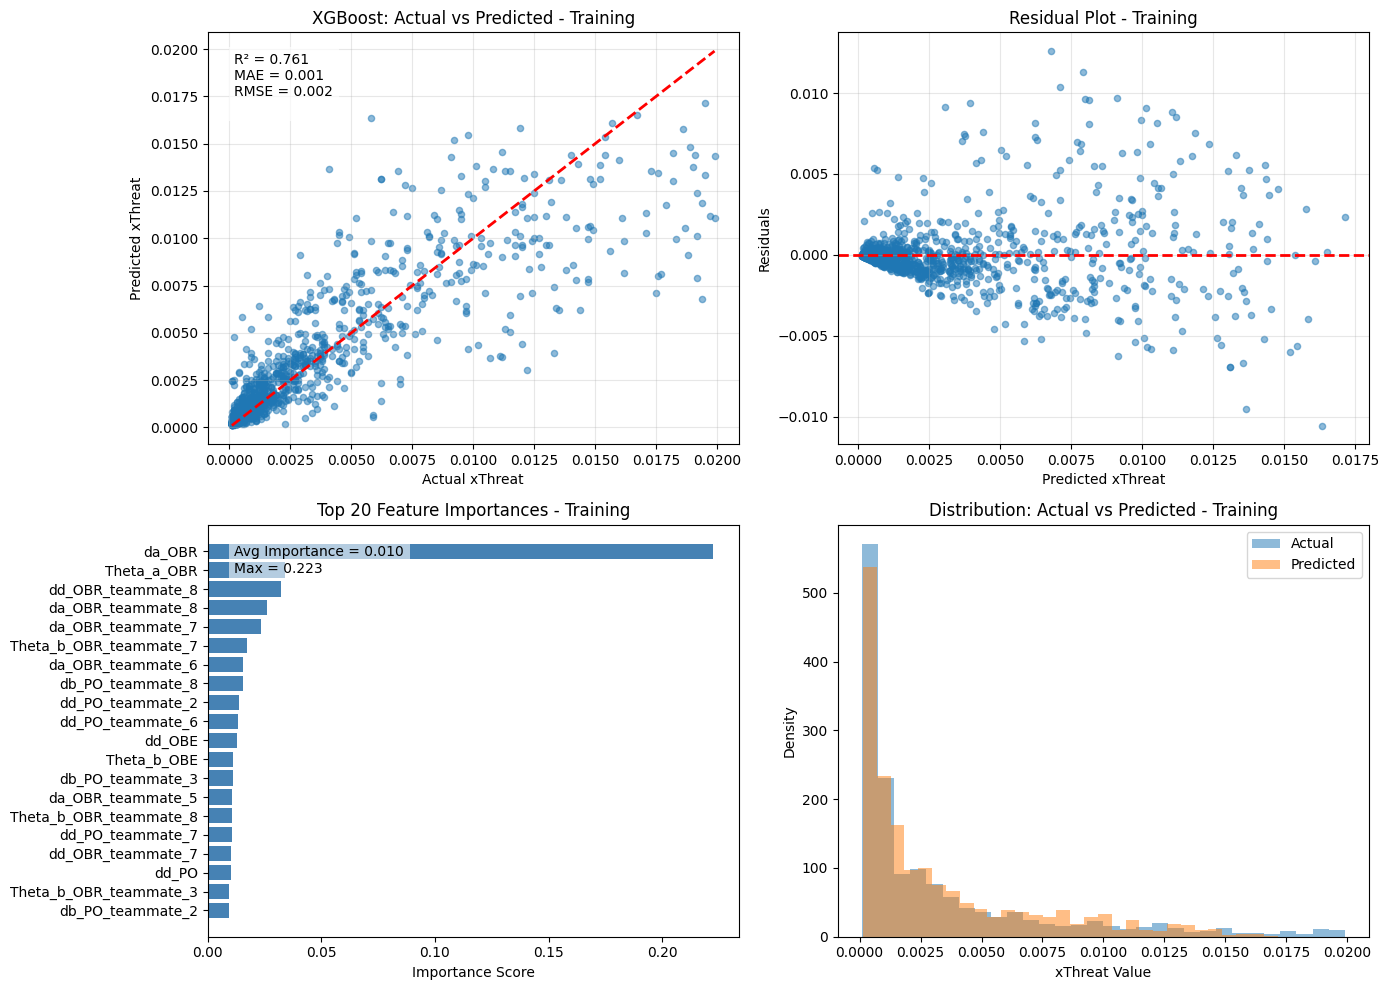

In [62]:
# XGBoost regression on training data
results = train_xgb_model(X, Y, M_train, test_size=0.2, random_state=42)

# Unpack parameters
(best_xgb_model, y_val, y_pred_best, importance_df, 
 r2_best, mae_best, rmse_best) = (
    results['best_model'],
    results['predictions']['y_val'], 
    results['predictions']['y_pred'],
    results['importance_df'],
    results['metrics']['R2'],
    results['metrics']['MAE'], 
    results['metrics']['RMSE']
)

# -----------------------------------
# VISUALIZATIONS WITH METRICS
# -----------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect metrics for display
text_metrics = (
    f"R² = {r2_best:.3f}\n"
    f"MAE = {mae_best:.3f}\n"
    f"RMSE = {rmse_best:.3f}\n"
)

# 1. Actual vs Predicted
axes[0, 0].scatter(y_val, y_pred_best, alpha=0.5, s=20)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual xThreat')
axes[0, 0].set_ylabel('Predicted xThreat')
axes[0, 0].set_title('XGBoost: Actual vs Predicted - Training')
axes[0, 0].text(
    0.05, 0.95, text_metrics,
    transform=axes[0, 0].transAxes,
    fontsize=10, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
residuals = y_val - y_pred_best
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted xThreat')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot - Training')
axes[0, 1].grid(True, alpha=0.3)

# Add residual std info
res_std = np.std(residuals)
axes[0, 1].text(
    0.05, 0.95, f"",
    transform=axes[0, 1].transAxes,
    fontsize=10, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

# 3. Feature Importance Plot
top_n = min(20, len(importance_df))
top_features = importance_df.head(top_n)
axes[1, 0].barh(range(top_n), top_features['importance'], color='steelblue')
axes[1, 0].set_yticks(range(top_n))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Importance Score')
axes[1, 0].set_title(f'Top {top_n} Feature Importances - Training')
axes[1, 0].invert_yaxis()

# Feature importance stats
avg_imp = importance_df['importance'].mean()
max_imp = importance_df['importance'].max()
axes[1, 0].text(
    0.05, 0.95, f"Avg Importance = {avg_imp:.3f}\nMax = {max_imp:.3f}",
    transform=axes[1, 0].transAxes,
    fontsize=10, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

# 4. Distribution Comparison
axes[1, 1].hist(y_val, alpha=0.5, bins=30, label='Actual', density=True)
axes[1, 1].hist(y_pred_best, alpha=0.5, bins=30, label='Predicted', density=True)
axes[1, 1].set_xlabel('xThreat Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Distribution: Actual vs Predicted - Training')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Save the best model
import joblib
joblib.dump(best_xgb_model, 'xgb_xthreat_best_model.pkl')

# Save feature importance
importance_df.to_csv('feature_importance.csv', index=False)


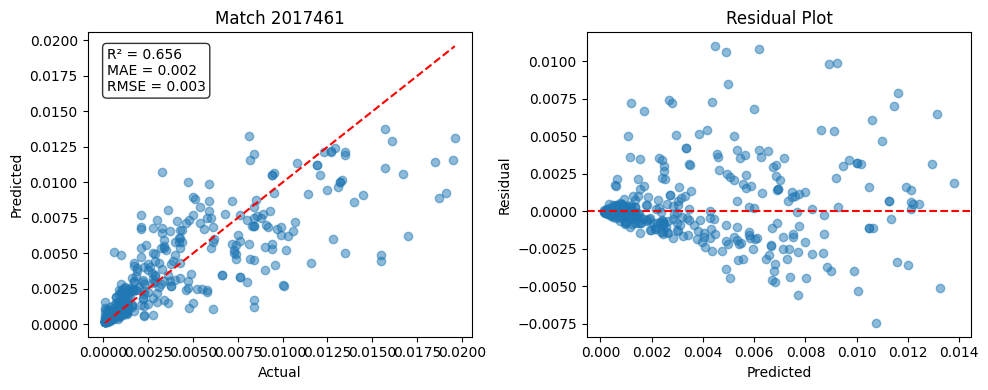

In [63]:
# XGBoost regression on test data

# Load trained model
model = joblib.load('xgb_xthreat_best_model.pkl')

# Load match data and create X and Y
M_test = M[M['match_id'] == match_id_test]
X = M_test.drop(columns = ['xthreat','match_id','frame','frame_type','possession_player_id','teammate_player_id','event_id']).values
Y = M_test[['xthreat']].values

# X = M_test.iloc[:, 1:-1].values
# Y = M_test.iloc[:, :1].values

# Predict
preds = model.predict(X)

# Save
results = pd.DataFrame({
    'actual': Y.flatten(),
    'predicted': preds
})
results.to_csv('match_predictions.csv', index=False)

# Plot
plt.figure(figsize=(10, 4))

# Calculate metrics
r2 = r2_score(Y, preds)
mae = mean_absolute_error(Y, preds)
rmse = np.sqrt(mean_squared_error(Y, preds))

# Subplot 1: Actual vs Predicted with metrics
plt.subplot(1, 2, 1)
plt.scatter(Y, preds, alpha=0.5)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Match {match_id_test}')

# Add metrics text to scatter plot
metrics_text = f'R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Subplot 2: Residual plot (clean, no text)
plt.subplot(1, 2, 2)
residuals = Y.flatten() - preds
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual Plot')

plt.tight_layout()
plt.savefig('match_predictions.png', dpi=100)
plt.show()


In [64]:
# Future analysis
    # Find local min and max xthreat by varying L's to determine best and worst intercept point P for a Defender
    # Freeze all metrics but vary da (OBR and PO) and vary db (OBE) to see the effect on xthreat by moving the play closer or further away from the goal  
    # Separate models for OBR and PO. Currently combining both datasets.
    # Inlcude OBR and PO events between Player Possesion start and end frames. Currently only considering events at the start and end frame.
    # Separate models for each team. Alternate ML models.
    # Deep dive into feature importance.